In [1]:
import math 
import numpy as np 
import matplotlib.pyplot as plt
import random
%matplotlib inline 

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
import torch


chars  = sorted(list(set([ch for w in words for ch in w])))
stoi = {ch:i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0

itos = {i+1:ch for i, ch in enumerate(chars)}
itos[0] = '.'



In [4]:
#bigram model 
b = {}

N = torch.ones((27,27), dtype=torch.int32) #We take ones as a smoothing factor

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1
        



(-0.5, 26.5, 26.5, -0.5)

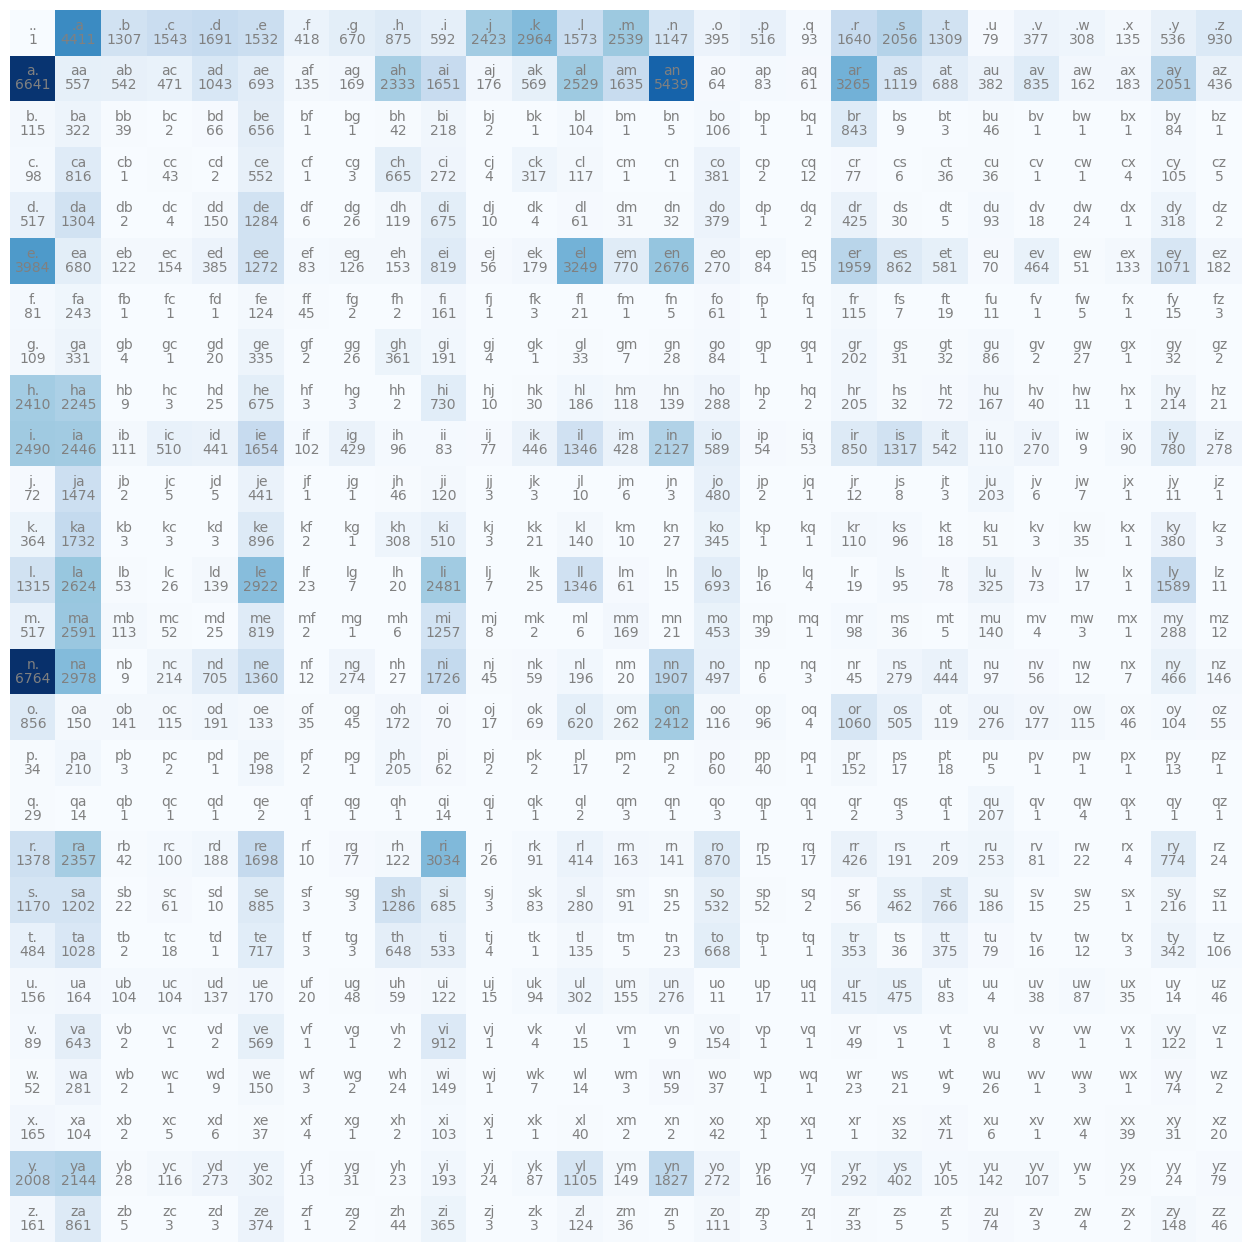

In [5]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')

In [6]:

P = N.float() 
P /= P.sum(dim=1, keepdim=True)

In [7]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    ix = 0
    out = []
    while True:
        p = P[ix].float()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        ch = itos[ix]
        if ch == '.':
            break
        out.append(ch)

    print(''.join(out))

cexze
momasurailezitynn
konimittain
llayn
ka
da
staiyaubrtthrigotai
moliellavo
ke
teda
ka
emimmsade
enkaviyny
ftlspihinivenvorhlasu
dsor
br
jol
pen
aisan
ja


In [8]:
#We are going to write out a simple loss function by taking the averaage negative log likelihood of the next character in the sequence.
loss = 0
n = 0



for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        loss -= math.log(P[ix1, ix2].item())
        n += 1

print(loss/n)



2.4545768218939177


In [13]:
#Create training set of all the bigrams (x,y) where x is the input and y is the output
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)


import torch.nn.functional as F
x_enc = F.one_hot(xs, num_classes=27).float()

g = torch.Generator().manual_seed(2147483647+1)
W = torch.randn((27,27), generator=g, requires_grad=True)

In [15]:
for k in range(1000):
    #forward pass
    logits = x_enc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[range(len(ys)), ys].log().mean() + 0.1 * (W**2).mean() #added regularization term
    print(loss.item())

    #backward pass
    W.grad = None
    loss.backward()
    W.data -= 50 * W.grad



2.587491512298584
2.5874476432800293
2.5874056816101074
2.587364912033081
2.5873262882232666
2.587289571762085
2.5872538089752197
2.587219715118408
2.587186813354492
2.5871551036834717
2.587125062942505
2.5870959758758545
2.587068557739258
2.5870418548583984
2.5870161056518555
2.586991548538208
2.586968183517456
2.5869455337524414
2.586923599243164
2.5869028568267822
2.5868825912475586
2.5868635177612305
2.5868451595306396
2.586827516555786
2.5868098735809326
2.586793899536133
2.586777687072754
2.5867629051208496
2.586747884750366
2.586733818054199
2.5867207050323486
2.586707592010498
2.5866949558258057
2.5866827964782715
2.5866715908050537
2.586660623550415
2.5866496562957764
2.586639642715454
2.586629629135132
2.5866198539733887
2.586610794067383
2.586601972579956
2.5865936279296875
2.586585283279419
2.5865774154663086
2.5865697860717773
2.5865626335144043
2.5865557193756104
2.5865488052368164
2.5865421295166016
2.586535692214966
2.5865297317504883
2.58652400970459
2.5865182876586914

In [16]:
#sample from the model

for i in range(20):
    ix = 0
    out = []
    while True:
        p = probs[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        ch = itos[ix]
        if ch == '.':
            break
        out.append(ch)

    print(''.join(out))

    

eocemlotrhgamweja
iayj
q
zari
ca
k
su
ljciarartrtweislralbia
a
mrtlglanleslkmkhld
azhanraliiabehanyknyeps
caefnb
bmlhynieygygawanveciizaneneklpjrqaejlpkrhgonyci
gitikyk
jstrtbijniia
jhonalnslsysnem
raciejpslsmi
jnykrtrytaemhcbc
ersneaiecshiiq
biayssdaiersekhfnmsnigs


In [62]:
#We attempt to create a trigram neural network model


chars  = sorted(list(set([ch for w in words for ch in w])))
stoi = {ch:i+3 for i, ch in enumerate(chars)}
stoi['.'] = 0
stoi['!'] = 1
stoi['?'] = 2

itos = {i+3:ch for i, ch in enumerate(chars)}
itos[0] = '.'
itos[1] = '!'
itos[2] = '?'


#Create training set of all the bigrams (x,y) where x is the input and y is the output
xs, ys = [], []
for w in words:
    w = '!.' + w + '.?'

    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append([ix1, ix2])
        ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

import torch.nn.functional as F
#here, we want to create a long 29+29 dimensional vector, with two ones in it, one for each of the two characters in the bigram
x_enc = F.one_hot(xs, num_classes=29).float()
print(x_enc.shape)
#we concatenate the two one-hot vectors together
x_enc = x_enc.reshape(-1, 58)
print(x_enc.shape)
print(x_enc[0])

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((58,29), generator=g, requires_grad=True)







torch.Size([260179, 2, 29])
torch.Size([260179, 58])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [71]:
for k in range(1000):
    #forward pass
    logits = x_enc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[range(len(ys)), ys].log().mean() + 0.1 * (W**2).mean() #added regularization term
    print(loss.item())

    #backward pass
    W.grad = None
    loss.backward()
    W.data -= 50 * W.grad

2.13628888130188
2.1362810134887695
2.136273145675659
2.136265993118286
2.136258363723755
2.136251211166382
2.1362438201904297
2.1362369060516357
2.1362297534942627
2.1362228393554688
2.136215925216675
2.13620924949646
2.136202812194824
2.1361961364746094
2.1361894607543945
2.136183261871338
2.1361770629882812
2.1361706256866455
2.136164903640747
2.1361587047576904
2.136152982711792
2.1361472606658936
2.136141300201416
2.1361355781555176
2.136129856109619
2.1361241340637207
2.1361191272735596
2.1361136436462402
2.1361083984375
2.1361031532287598
2.1360979080200195
2.1360926628112793
2.1360878944396973
2.136082887649536
2.136078119277954
2.136073350906372
2.136068820953369
2.136064052581787
2.136059522628784
2.1360549926757812
2.136050224304199
2.1360459327697754
2.1360414028167725
2.1360373497009277
2.136033058166504
2.136029005050659
2.1360249519348145
2.1360208988189697
2.136016845703125
2.136012554168701
2.1360087394714355
2.136005163192749
2.1360013484954834
2.135997772216797
2.135

In [74]:
#we sample from the model
for i in range(20):
    #we start with the two characters in the bigram, !.
    ix = [1, 0]
    #one hot encode the two characters
    x = F.one_hot(torch.tensor(ix), num_classes=29).float()
    #concatenate the two one-hot vectors
    x = x.reshape(-1, 58)

    out = []
    
    while True:
        #forward pass
        logits = x @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)
        #sample from the distribution
        next_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        ch = itos[next_ix]
        if ch == '.':
            break
        out.append(ch)
        #update the input
        ix = [ix[1], next_ix]
        x = F.one_hot(torch.tensor(ix), num_classes=29).float()
        x = x.reshape(-1, 58)

    print(''.join(out))
        
    

aath
anse
lailan
kareomye
ary
dalihakyarisnn
ha
oany
llh
dily
rilithymynn
me
mi
mazlau!cker
dabdyle
usiylest
taveis
shrmiy
kiarnav
jedieckarie


In [81]:
# Now we take the previous model and add a hidden layer to it
chars  = sorted(list(set([ch for w in words for ch in w])))
stoi = {ch:i+3 for i, ch in enumerate(chars)}
stoi['.'] = 0
stoi['!'] = 1
stoi['?'] = 2

itos = {i+3:ch for i, ch in enumerate(chars)}
itos[0] = '.'
itos[1] = '!'
itos[2] = '?'

#Create training set of all the bigrams (x,y) where x is the input and y is the output
xs, ys = [], []
for w in words:
    w = '!.' + w + '.?'

    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append([ix1, ix2])
        ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

import torch.nn.functional as F
#here, we want to create a long 29+29 dimensional vector, with two ones in it, one for each of the two characters in the bigram
x_enc = F.one_hot(xs, num_classes=29).float()
#we concatenate the two one-hot vectors together
x_enc = x_enc.reshape(-1, 58)


g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((58,20), generator=g, requires_grad=True)
W2 = torch.randn((20,29), generator=g, requires_grad=True)



torch.Size([260179, 2, 29])
torch.Size([260179, 58])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [85]:
for k in range(100):
    #forward pass
    h = x_enc @ W1
    logits = h @ W2
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[range(len(ys)), ys].log().mean() + 0.1 * (W1**2).mean() + 0.1 * (W2**2).mean() #added regularization term
    print(loss.item())

    #backward pass
    W1.grad = None
    W2.grad = None
    loss.backward()
    W1.data -= 0.1 * W1.grad
    W2.data -= 0.1 * W2.grad

2.4591457843780518
2.458829164505005
2.4585134983062744
2.4581985473632812
2.4578840732574463
2.4575700759887695
2.45725679397583
2.456944227218628
2.456631898880005
2.456320285797119
2.456010103225708
2.455699920654297
2.455390453338623
2.4550814628601074
2.454773187637329
2.454465627670288
2.4541587829589844
2.4538516998291016
2.4535462856292725
2.4532413482666016
2.4529364109039307
2.452632427215576
2.452329397201538
2.4520263671875
2.4517242908477783
2.451422691345215
2.4511218070983887
2.4508213996887207
2.450521469116211
2.4502222537994385
2.449923515319824
2.4496257305145264
2.449328660964966
2.4490318298339844
2.448735237121582
2.448439836502075
2.4481446743011475
2.447850227355957
2.447556734085083
2.447263240814209
2.446970224380493
2.4466781616210938
2.4463863372802734
2.4460959434509277
2.445805072784424
2.4455149173736572
2.445225954055786
2.444936990737915
2.4446489810943604
2.444361448287964
2.4440743923187256
2.4437878131866455
2.4435017108917236
2.443216323852539
2.442

In [86]:
#we sample from the model

for i in range(20):
    #we start with the two characters in the bigram, !.
    ix = [1, 0]
    #one hot encode the two characters
    x = F.one_hot(torch.tensor(ix), num_classes=29).float()
    #concatenate the two one-hot vectors
    x = x.reshape(-1, 58)

    out = []
    
    while True:
        #forward pass
        h = x @ W1
        logits = h @ W2
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)
        #sample from the distribution
        next_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        ch = itos[next_ix]
        if ch == '.':
            break
        out.append(ch)
        #update the input
        ix = [ix[1], next_ix]
        x = F.one_hot(torch.tensor(ix), num_classes=29).float()
        x = x.reshape(-1, 58)

    print(''.join(out))
    

loni
sliy
jamdde
tah
yadeyllis
sandeyn
maliisaluhavt?zvelan
yannuis!hresaudgyser
yanson
aide
yh
dena
son
gialin
kelerah
kilkel
aiosth
yahanalahdmyn
sah
monilyanira


In [89]:
# Now we take the previous model and add a hidden layer to it
chars  = sorted(list(set([ch for w in words for ch in w])))
stoi = {ch:i+5 for i, ch in enumerate(chars)}
stoi['.'] = 0
stoi['!'] = 1
stoi['?'] = 2
stoi[' '] = 3
stoi['-'] = 4


itos = {i+5:ch for i, ch in enumerate(chars)}
itos[0] = '.'
itos[1] = '!'
itos[2] = '?'
itos[3] = ' '
itos[4] = '-'


#Create training set of all the bigrams (x,y) where x is the input and y is the output
xs, ys = [], []
for w in words:
    w = ' !.' + w + '.?-'

    for ch1, ch2, ch3, ch4 in zip(w, w[1:], w[2:], w[3:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        ix4 = stoi[ch4]
        xs.append([ix1, ix2, ix3])
        ys.append(ix4)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

import torch.nn.functional as F
#here, we want to create a long 29+29 dimensional vector, with two ones in it, one for each of the two characters in the bigram
x_enc = F.one_hot(xs, num_classes=31).float()
#we concatenate the two one-hot vectors together
x_enc = x_enc.reshape(-1, 31*3)


g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((31*3,20), generator=g, requires_grad=True)
W2 = torch.randn((20,31*3), generator=g, requires_grad=True)

In [92]:
for k in range(100):
    #forward pass
    h = x_enc @ W1
    logits = h @ W2
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[range(len(ys)), ys].log().mean() + 0.1 * (W1**2).mean() + 0.1 * (W2**2).mean() #added regularization term
    print(loss.item())

    #backward pass
    W1.grad = None
    W2.grad = None
    loss.backward()
    W1.data -= 1 * W1.grad
    W2.data -= 1 * W2.grad

2.4340059757232666
2.4274954795837402
2.421135187149048
2.4149210453033447
2.408848285675049
2.4029135704040527
2.3971126079559326
2.391442060470581
2.385897636413574
2.380476236343384
2.3751730918884277
2.369986057281494
2.36491060256958
2.3599438667297363
2.3550822734832764
2.3503224849700928
2.3456623554229736
2.341097354888916
2.3366262912750244
2.332245111465454
2.327951431274414
2.323742628097534
2.3196163177490234
2.3155698776245117
2.311601400375366
2.3077080249786377
2.3038883209228516
2.3001394271850586
2.296459436416626
2.2928476333618164
2.2893004417419434
2.2858169078826904
2.282395601272583
2.27903413772583
2.2757318019866943
2.2724862098693848
2.269296169281006
2.266160488128662
2.2630774974823
2.2600460052490234
2.2570650577545166
2.2541329860687256
2.251248359680176
2.248410701751709
2.2456188201904297
2.2428717613220215
2.240168571472168
2.2375082969665527
2.2348906993865967
2.2323150634765625
2.22978138923645
2.2272911071777344
2.224844455718994
2.222445249557495
2.2

In [104]:
# We sample from the model

for i in range(20):
    #we start with the two characters in the bigram, 
    ix = [3,1,0]
    #one hot encode the two characters
    x = F.one_hot(torch.tensor(ix), num_classes=31).float()
    #concatenate the two one-hot vectors
    x = x.reshape(-1, 31*3)

    out = []
    
    while True:
        #forward pass
        h = x @ W1
        logits = h @ W2
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)
        #sample from the distribution
        next_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        ch = itos[next_ix]
        if ch == '.':
            break
        out.append(ch)
        #update the input
        ix = [ix[1], ix[2], next_ix]
        x = F.one_hot(torch.tensor(ix), num_classes=31).float()
        x = x.reshape(-1, 31*3)

    print(''.join(out))

ardea
b
tna
leeno
rascaismynrial
pamaae
aaurionaahaellayionnn
arlyna
eal
nelaa
crinneerilmaaneethann
gmoliahvad
akabesmareynna
ea
erlaykannooti
iamarei
jlasamaberliyah
zamiris
del
han
